### 1. Procesamiento y visualizacion de los datos

In [1]:
#Primero importamos las librerias necesarias
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed 
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Para reproducibilidad
np.random.seed(1)
tf.random.set_seed(1)

C:\Users\ricar\AppData\Local\Temp\ipykernel_20556\3511180871.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')


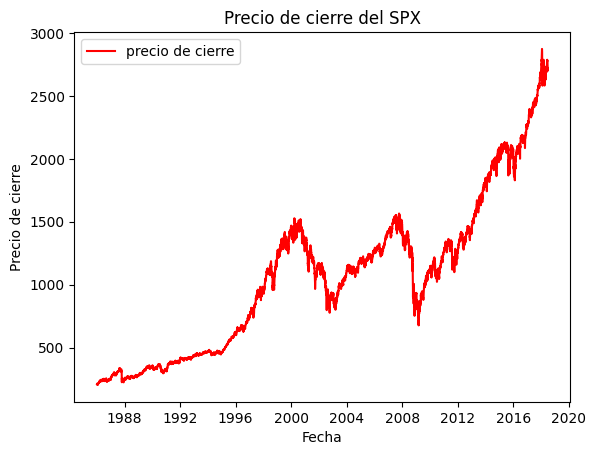

In [2]:
#Cargamos los datos 
data = pd.read_csv('spx.csv', parse_dates=['date'], index_col='date')

# Realizamos una visualización de los datos
plt.plot(data, label = 'precio de cierre', color='red')
plt.title('Precio de cierre del SPX')
plt.xlabel('Fecha')
plt.ylabel('Precio de cierre')
plt.legend()

Para los datos de entrenamiento y los datos de prueba se usara 90% y 10% respectivamente

In [3]:
# Separamos los datos en entrenamiento y prueba
train_data, test_data = train_test_split(data, test_size=0.1, shuffle=False)
print(train_data.shape, test_data.shape)

# Usamos un scaler para normalizar los datos
scaler = StandardScaler()
scaler = scaler.fit(train_data[['close']])
# Transformamos los datos de entrenamiento y prueba
train_data['close'] = scaler.transform(train_data[['close']]) 
test_data['close'] = scaler.transform(test_data[['close']])

(7372, 1) (820, 1)


### **Creación de Secuencias para Modelos de Series Temporales**

En los modelos de series temporales, como los LSTM, es necesario organizar los datos en secuencias para que el modelo pueda aprender de los datos pasados y predecir los futuros.

La función **`crear_secuencia`** permite transformar los datos en secuencias, donde cada secuencia contiene un número de pasos de tiempo (`time_steps`) y su correspondiente etiqueta (el siguiente valor en la serie temporal). Esta transformación es fundamental para entrenar modelos como LSTM, que requieren entradas en forma de secuencias.

* **Entrenamiento y prueba**: Usamos **`crear_secuencia`** para generar secuencias para los conjuntos de entrenamiento y prueba, utilizando una ventana de 10 pasos de tiempo.
* **Reformateo para LSTM**: Las secuencias generadas se reestructuran en formato 3D, con dimensiones `(muestras, pasos de tiempo, características)`, que es el formato esperado por los modelos LSTM.
* **Verificación**: Se verifican las dimensiones de las secuencias generadas para asegurar que estén correctamente estructuradas antes de ser alimentadas al modelo.

Este proceso garantiza que los datos estén en el formato adecuado para entrenar modelos de series temporales.


In [4]:
def crear_secuencia(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

# Aplicamos la función crear_secuencia para generar secuencias de entrenamiento y prueba

# Definimos el número de pasos de tiempo
time_steps = 35

# Creamos las secuencias para el conjunto de entrenamiento
X_train, y_train = crear_secuencia(train_data[['close']], train_data.close, time_steps)
# Creamos las secuencias para el conjunto de prueba
X_test, y_test = crear_secuencia(test_data[['close']], test_data.close, time_steps)

# imprimimos las dimensiones de las secuencias generadas
print(X_train.shape)
print(X_test.shape)

(7337, 35, 1)
(785, 35, 1)


In [ ]:
BATCH_SIZE = 64
ACCUMULATION_STEPS = 4
EPOCHS = 10

# Modelo LSTM ejemplo
def create_lstm_model(input_shape, output_dim=1):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50),
        Dense(output_dim)
    ])
    return model

# Optimizador y función de pérdida
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.MeanAbsoluteError()

# Ciclo de entrenamiento con acumulación de gradientes
def train_with_gradient_accumulation(model, train_dataset, epochs, batch_size, accumulation_steps):
    for epoch in range(epochs):
        epoch_loss = 0.0
        batch_count = 0
        
        # Inicializar gradientes acumulados
        accumulated_gradients = [tf.Variable(tf.zeros_like(var), trainable=False) 
                               for var in model.trainable_variables]
        
        for step, (x_batch, y_batch) in enumerate(train_dataset):
            with tf.GradientTape() as tape:
                predictions = model(x_batch, training=True)
                loss = loss_fn(y_batch, predictions)
                # Escalar pérdida por pasos de acumulación
                scaled_loss = loss / accumulation_steps
            
            # Calcular gradientes
            gradients = tape.gradient(scaled_loss, model.trainable_variables)
            
            # Acumular gradientes
            for i, grad in enumerate(gradients):
                accumulated_gradients[i].assign_add(grad)
            
            epoch_loss += loss
            batch_count += 1
            
            # Aplicar gradientes cada accumulation_steps
            if (step + 1) % accumulation_steps == 0:
                optimizer.apply_gradients(zip(accumulated_gradients, model.trainable_variables))
                
                # Reinicializar gradientes acumulados
                for acc_grad in accumulated_gradients:
                    acc_grad.assign(tf.zeros_like(acc_grad))
        
        # Aplicar gradientes restantes si no se completó un ciclo
        if batch_count % accumulation_steps != 0:
            optimizer.apply_gradients(zip(accumulated_gradients, model.trainable_variables))
        
        avg_loss = epoch_loss / batch_count
        print(f'Época {epoch + 1}/{epochs}, Pérdida: {avg_loss:.4f}')

# Ejemplo de uso
def create_sample_data(samples=1000, timesteps=10, features=5):
    X = np.random.randn(samples, timesteps, features)
    y = np.random.randn(samples, 1)
    return X, y

# Crear datos y dataset
X_train, y_train = create_sample_data()
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(BATCH_SIZE)

# Crear y entrenar modelo
model = create_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2]))

print('Iniciando entrenamiento con acumulación de gradientes...')
train_with_gradient_accumulation(model, train_dataset, EPOCHS, BATCH_SIZE, ACCUMULATION_STEPS)
